<a href="https://colab.research.google.com/github/HuangLorenzo/Esame_python/blob/main/Huang_lorenzo_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import librerie e dati

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [101]:
!pip install optuna
import optuna

In [102]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
SFRH_simulazioni = np.load('/content/drive/MyDrive/Colab Notebooks/esamepython/SFRH_IllustrisTNG.npy')
param_simulazioni=np.loadtxt('/content/drive/MyDrive/Colab Notebooks/esamepython/params_IllustrisTNG.txt')

In [105]:
def has_duplicates(arr):
  # Convert each row to a tuple and then use np.unique to find unique tuples
  unique_rows = np.unique(arr, axis=0)
  return len(unique_rows) != len(arr)

# Example usage
vector_of_vectors = param_simulazioni
if has_duplicates(vector_of_vectors):
  print("The vector of vectors has duplicates.")
else:
  print("The vector of vectors does not have duplicates.")

The vector of vectors does not have duplicates.


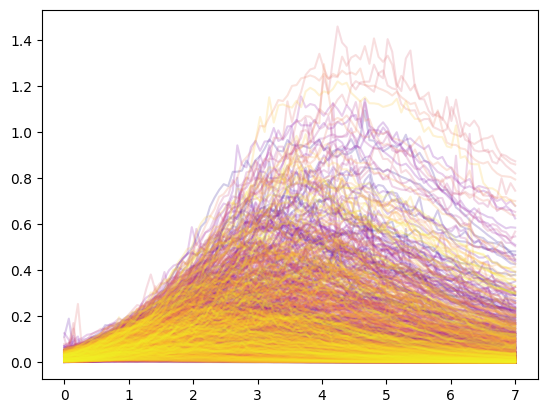

In [106]:
z=np.linspace(0.0, 7.0, 100)
cmap=plt.get_cmap('plasma')
colors=[cmap(i) for i in np.linspace(0,1,len(SFRH_simulazioni))]
for i in range(len(SFRH_simulazioni)):
  plt.plot(z,SFRH_simulazioni[i],c=colors[i], alpha=0.2)
plt.show()

#sezione test funzionamento ML

##hyper parameters

In [157]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-2                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 5000                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 50                       #size of hidden layer (see nn.Linear)

f_model = 'best_model.pt'                  # Where to save the trained model

## datasets

In [158]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [159]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):
        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y,  axis=0)
        y = (y - mean)/std







        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,100), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,6),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        print(self.input.shape,self.output.shape)

        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [160]:
train_loader = create_dataset('train', SFRH_simulazioni, param_simulazioni, batch_size, seed)
valid_loader = create_dataset('valid', SFRH_simulazioni, param_simulazioni, batch_size, seed)
test_loader  = create_dataset('test', SFRH_simulazioni, param_simulazioni, batch_size, seed)

torch.Size([700, 100]) torch.Size([700, 6])
torch.Size([150, 100]) torch.Size([150, 6])
torch.Size([150, 100]) torch.Size([150, 6])


## NN constructor functions

In [161]:
def model_builder(number_layers,hidden_size):
  layers=[]

  #creazione del modello
  layers.append(nn.Linear(100,hidden_size))
  for i in range(number_layers):
    layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_size,hidden_size))
  layers[2*number_layers]=nn.Linear(hidden_size,6)

  return nn.Sequential(*layers)


In [162]:
def build_model_custom(n_layers,hidden_size):

    # Suggest the number of layers of neural network model
    layers = []

    in_features = 100
    out_features = 6

    for i in range(n_layers):
        layers.append(nn.Linear(in_features, hidden_size))
        layers.append(nn.LeakyReLU())
        in_features = hidden_size

    layers.append(nn.Linear(in_features, out_features))

    return nn.Sequential(*layers)

In [163]:
def nn_training(model,lr,epochs,trial=None):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)
  min_valid_loss=min_valid_loss_param
  train_value=np.zeros(epochs)
  valid_value=np.zeros(epochs)
  global epoch_best_model

  # update the learning rate after patience-stesp if the loss function does not improve
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-6)




  #funzioneloss
  loss_func = nn.MSELoss()


  for epoch in range(epochs):
    train_loss = 0.0
    points=0.0
    model.train()
    for i, (input, output) in enumerate(train_loader):
      # get the size of the batch
      bs = input.shape[0]

      #spostare i dati nel GPU se è disponibile
      input = input.to(device)
      output = output.to(device)

      #modello output
      output_pred = model(input)

      #calcolo scarto medio quadratico
      loss = loss_func(output_pred, output)

      #gradiente
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #accumulo loss del ciclo sui batch
      train_loss += loss.item()*bs
      points+=bs

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss

    #validation
    valid_loss = 0.0
    points=0.0
    model.eval()


    #disattivo gradiente
    with torch.no_grad():

      #ciclo valid_batch
      for i, (input, output) in enumerate(valid_loader):
       # get the size of the batch
        bs = input.shape[0]

        #spostare i dati nel GPU se è disponibile
        input = input.to(device)
        output = output.to(device)

        #modello output
        output_pred = model(input)

        #calcolo scarto medio quadratico
        loss = loss_func(output_pred, output)

        #accumula loss
        valid_loss += (loss.item())*bs
        points     += bs

      valid_loss/=points
      valid_value[epoch]=valid_loss

    #attivo scheduler
    scheduler.step(valid_loss)

    # save model if it has a lower validation loss
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')

    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break
    if trial is not None:
      trial.report(min_valid_loss, epoch)
      if trial.should_prune():
        raise optuna.TrialPruned()
  return train_value,valid_value,min_valid_loss

## actual training

In [164]:
#costruisci sempre un modello prima del training senno il trainig parte da parametri gia ottimizzati
model=build_model_custom(3,hidden_size=hidden_size)
model=model.to(device)
print(model)

train_value,valid_value,_=nn_training(model=model,lr=lr,epochs=epochs)

Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=50, out_features=6, bias=True)
)
epoch:0, valid loss: 0.7102 (best-model)
epoch:1, valid loss: 0.6710 (best-model)
epoch:2, valid loss: 0.6687 (best-model)
epoch:3, valid loss: 0.6809
epoch:4, valid loss: 0.6665 (best-model)
epoch:5, valid loss: 0.6424 (best-model)
epoch:6, valid loss: 0.6391 (best-model)
epoch:7, valid loss: 0.6224 (best-model)
epoch:8, valid loss: 0.6635
epoch:9, valid loss: 0.6143 (best-model)
epoch:10, valid loss: 0.7023
epoch:11, valid loss: 0.6714
epoch:12, valid loss: 0.5826 (best-model)
epoch:13, valid loss: 0.5778 (best-model)
epoch:14, valid loss: 0.6164
epoch:15, valid loss: 0.5818
epoch:16, valid loss: 0.6504
epoch:17, valid loss: 0.565

## graph

[]

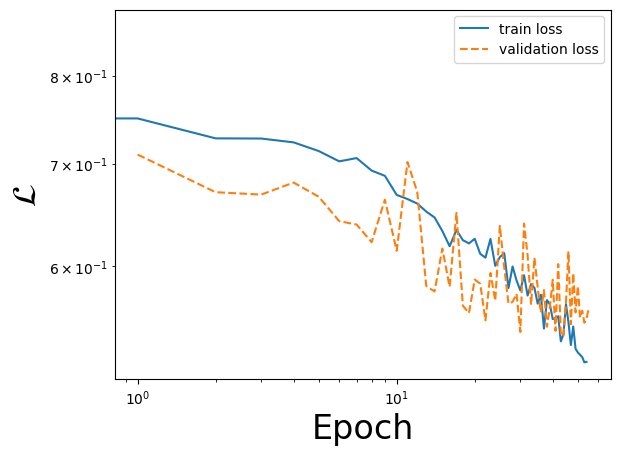

In [165]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='train loss')
plt.plot(epoche+1,valid_value[:epoch_best_model],ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()

In [ ]:
loss_func = nn.MSELoss()

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# define arraies where to store stuff

x_values=np.zeros((len(test_loader.dataset),100))
y_true=np.zeros((len(test_loader.dataset),6))
y_NN=np.zeros((len(test_loader.dataset),6))

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
with torch.no_grad():
  for x_test, y_test in test_loader:
    bs=x_test.shape[0]

    # move data to GPU
    x_test   = x_test.to(device)
    y_test = y_test.to(device)

    # make prediction using network
    y_pred = model(x_test)

    # Store predictions and true parameter values
    # Need to move the array to cpu() and make it numpy()
    # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
    # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
    x_values[counter:counter+bs,:]=x_test
    y_true[counter:counter+bs,:]= y_test.cpu().numpy()
    y_NN[counter:counter+bs,:]= y_pred.cpu().numpy()


    # compute cumulative loss and number of examples used
    test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
    points += x_test.shape[0]

    counter += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)
plt.plot(np.linspace(-2,2,1000),np.linspace(-2,2,1000))
plt.scatter(y_true[:,0],y_NN[:,0],label='$\Omega_m$')

#Optuna section

In [ ]:
def objective(trial):
  params = {
      'number_layers': trial.suggest_int('number_layers', 1, 4,),
      'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
      'epochs': trial.suggest_int("epochs", 100, 500),
      'hidden_size': trial.suggest_int("hidden_size", 50, 100) # number of hidden parameters
       }
  #salvo i nuovi parametri
  number_layers=params['number_layers']
  hidden_size=params['hidden_size']
  lr=params['learning_rate']
  epochs=params['epochs']

  #costruisco modello
  model=model_builder(number_layers=number_layers,hidden_size=hidden_size)
  model=model.to(device)


  #accuracy

  _,_,accuracy=nn_training(model=model,lr=lr,epochs=epochs,trial=trial)

  return accuracy




In [ ]:
# Let's also add a method (prune) to terminate unpromising trials in the early stages of the training process
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.PercentilePruner(80.))
study.optimize(objective, n_trials=30)

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
# Generate a visualization of the intermediate values recorded during the
# hyperparameter optimization process
optuna.visualization.plot_intermediate_values(study)

In [ ]:
# Plot how the best objective function value found so far changes as the
# optimization progresses (i.e., as more trials are completed)
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Visualize the relationships between multiple hyperparameters and their
# impact on the objective function (e.g., validation loss) that you're trying to
# optimize.

# Vertical Axes: Each vertical axis represents a hyperparameter or the objective value (e.g. validation loss) that's being optimized.
# Lines: Each line represents a single trial in your optimization. The point where a line intersects with an axis corresponds to the value of that hyperparameter (or the objective value) for that trial.
# Color: Often, the lines are colored according to the objective function value (e.g., trials with lower validation loss might be a different color).

optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# Visualize the relative importance of the hyperparameters in optimazing the
# objective function (e.g., validation loss)
optuna.visualization.plot_param_importances(study)

#Sezione test ML2

##hyper parameters

In [166]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-2                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 5000                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 50                       #size of hidden layer (see nn.Linear)

f_model = 'best_model.pt'                  # Where to save the trained model

## datasets

In [167]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [168]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):

        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y,  axis=0)
        y = (y - mean)/std


        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,100), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,6),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)


        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [175]:
print(SFRH_simulazioni.shape,param_simulazioni.shape)


# get the data for training and validation
train_loader = create_dataset('train', SFRH_simulazioni, param_simulazioni, batch_size, seed) #training data
valid_loader = create_dataset('valid', SFRH_simulazioni, param_simulazioni, batch_size, seed) #validation data

(1000, 100) (1000, 6)


##Model

In [170]:
Nin= 100 # input size
Nout= 6 # output size
model = nn.Sequential(
            nn.Linear(Nin, hidden_size),
            nn.ReLU(),
            # nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, Nout))

#move it to the GPU
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 5356


##Training

In [171]:
loss_func = nn.MSELoss()  #loss function. In this case MSE (mean squared error)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

In [172]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss=min_valid_loss_param

# Define a scheduler to change the learning rate according to some criteria
# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size_lr, gamma=0.5) # update the learning rate after step_size
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                    min_lr= 1.0e-6, verbose=True) # update the learning rate after patience-stesp if the loss function does not improve
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for x_train, y_train in train_loader:  #do a loop over all elements in the training set

        # get the size of the batch
        bs = x_train.shape[0]

        # move data to GPU
        y_train = y_train.to(device)
        x_train   = x_train.to(device)

        # compute the value predicted by the network
        y_pred  = model(x_train)

        # compute loss
        loss = loss_func(y_pred, y_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())*bs
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for x_val, y_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the size of the batch
            bs = x_val.shape[0]

            # move data to the GPU
            y_val = y_val.to(device)
            x_val   = x_val.to(device)

            # compute prediction by the network
            y_pred = model(x_val)

            # compute cumulative loss and number of examples used
            valid_loss += (loss_func(y_pred, y_val).item())*bs
            points     += bs

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the lr

    # save model if it has a lower validation loss
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

epoch:0, valid loss: 0.7287 (best-model)
epoch:1, valid loss: 0.6834 (best-model)
epoch:2, valid loss: 0.7059


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



epoch:3, valid loss: 0.6936
epoch:4, valid loss: 0.6283 (best-model)
epoch:5, valid loss: 0.6428
epoch:6, valid loss: 0.6372
epoch:7, valid loss: 0.6289
epoch:8, valid loss: 0.6138 (best-model)
epoch:9, valid loss: 0.6109 (best-model)
epoch:10, valid loss: 0.6727
epoch:11, valid loss: 0.5956 (best-model)
epoch:12, valid loss: 0.6043
epoch:13, valid loss: 0.6080
epoch:14, valid loss: 0.5946 (best-model)
epoch:15, valid loss: 0.6082
epoch:16, valid loss: 0.6076
epoch:17, valid loss: 0.6197
epoch:18, valid loss: 0.5890 (best-model)
epoch:19, valid loss: 0.5908
epoch:20, valid loss: 0.5869 (best-model)
epoch:21, valid loss: 0.5914
epoch:22, valid loss: 0.5739 (best-model)
epoch:23, valid loss: 0.5970
epoch:24, valid loss: 0.6060
epoch:25, valid loss: 0.6074
epoch:26, valid loss: 0.5885
epoch:27, valid loss: 0.6447
epoch:28, valid loss: 0.5778
epoch:29, valid loss: 0.5967
epoch:30, valid loss: 0.5697 (best-model)
epoch:31, valid loss: 0.5957
epoch:32, valid loss: 0.5835
epoch:33, valid loss

[]

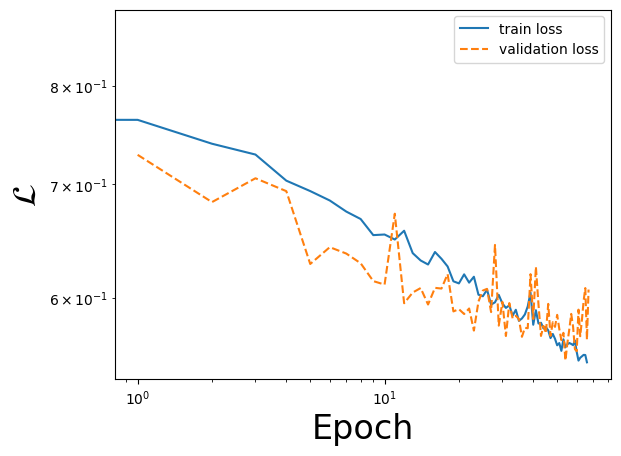

In [173]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='train loss')
plt.plot(epoche+1,valid_value[:epoch_best_model],ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()